In [18]:
import os
import re
import pandas as pd
import numpy as np
#pre processamento
import nltk
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#glove
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
#modelo
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import tensorflow as tf
#avalição
from sklearn.metrics import classification_report, confusion_matrix
#plot
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
#baixando pacotes necessários
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MGPFILH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MGPFILH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MGPFILH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Impotação da Base de dados

In [20]:
df = pd.read_csv('DATA/FakeNews.csv') #https://www.kaggle.com/datasets/algord/fake-news
#df = pd.read_csv('DATA/gossipcop_data.csv')
#df = pd.read_csv('DATA/politifact_data.csv')
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


Tratamento da base de dados

In [21]:
def process_df(df):
    df.dropna(inplace=True) #removendo valores nulos
    df.drop_duplicates(subset='title', keep='last', inplace=True) #removendo duplicatas
    df.reset_index(drop=True, inplace=True) #resetando index
    df['title'] = df['title'].apply(lambda text: re.sub(r"[^A-Za-z0-9\s\.]", '', text.lower())) #removendo caracteres especiais
    return df

Balanceamento de Carga

In [22]:
def balance_data(df):
    df_fake = df[df['real'] == 0]
    df_real = df[df['real'] == 1]
    df_real_downsampled = resample(df_real, replace=False, n_samples=len(df_fake), random_state=42) #balanceando dados
    df_balanced = pd.concat([df_real_downsampled, df_fake])
    
    return df_balanced, df_balanced['real']

Aplicação do tratamento, divisão e balanceamento de dados

In [23]:
#aplicando tratamento
df = process_df(df)
print(df.shape)
print(df['real'].value_counts()) #1 real 0 fake

#dividindo dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df, df['real'], test_size=0.2, random_state=42)

#balanceando dados de treino
X_train, y_train = balance_data(X_train)
print("\nDados de treino:",X_train.shape)
print(y_train.value_counts())
print("\nDados de teste:", X_test.shape)
print(y_test.value_counts())

(21398, 5)
1    16392
0     5006
Name: real, dtype: int64

Dados de treino: (7940, 5)
1    3970
0    3970
Name: real, dtype: int64

Dados de teste: (4280, 5)
1    3244
0    1036
Name: real, dtype: int64


## PROCESSAMENTO DE LINGUAGEM NATURAL (PLN)

Tokenização, StopWords, Lematização

In [24]:
def process_data(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text) #tokenização
    tokens = [token for token in tokens if token not in stop_words] #remoção de stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #lematização
    preprocessed_text = ' '.join(tokens) #junção de tokens
    
    return preprocessed_text

TF-IDF

In [25]:
def calculate_tfidf(train_text, test_text):
    vectorizer = TfidfVectorizer()
    tfidf_matrix1 = vectorizer.fit_transform(train_text) #treinamento
    tfidf_matrix2 = vectorizer.transform(test_text) #teste
    return tfidf_matrix1.toarray(), tfidf_matrix2.toarray()

GloVe

In [26]:
#Carregando Stanford GloVe mode
glove_filename = 'DATA/glove.6b/glove.6B.100d.txt' 
glove_path = os.path.abspath(glove_filename)
word2vec_output_file = glove_filename +'.word2vec'
glove2word2vec(glove_path, word2vec_output_file) #convertendo GloVe para word2vec
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False) 

#Calculando GloVe
def calculate_glove(train_text, test_text):
    vectorizer = Word2VecVectorizer(glove_model)
    X_train_glove = vectorizer.fit_transform(train_text) #calculando GloVe
    X_test_glove = vectorizer.transform(test_text) #calculando GloVe
    return X_train_glove, X_test_glove

#Classe para vetorização de textos
class Word2VecVectorizer:
    def __init__(self, model):
        self.word_vectors = model
        self.D = model.vector_size

    def fit(self, data):
        pass

    def transform(self, data):
        X = np.zeros((len(data), self.D))
        emptycount = 0
        for i, sentence in enumerate(data):
            tokens = sentence.split()
            vecs = []
            for word in tokens:
                try:
                    vec = self.word_vectors[word]
                    vecs.append(vec)
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[i] = vecs.mean(axis=0)
            else:
                emptycount += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

C:\Users\MGPFILH\AppData\Local\Temp\ipykernel_24136\455720955.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file) #convertendo GloVe para word2vec


Aplicação do PLN

In [27]:
#aplicando tokenização, stopWords, lematização
X_train['tokens'] = X_train['title'].apply(process_data)
X_test['tokens'] = X_test['title'].apply(process_data)

#TF-IDF
#X_train, X_test = calculate_tfidf(X_train['tokens'], X_test['tokens'])
#method = 'TF-IDF'

#GloVe
X_train, X_test= calculate_glove(X_train['tokens'], X_test['tokens'])
method = 'GloVe'

Number of samples with no words found: 13 / 7940
Number of samples with no words found: 7 / 4280


## MODELOS ARTIFICIAIS

Naive Bayes

In [28]:
def naive_bayes_model(X_train, y_train, X_test):
    naive_bayes = MultinomialNB()
    naive_bayes.fit(X_train, y_train) #treinando modelo
    y_pred = naive_bayes.predict(X_test) #testando modelo
    return y_pred

Floresta Aleatória

In [29]:
def random_forest_model(X_train, y_train, X_test):
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train) #treinando modelo
    y_pred = random_forest.predict(X_test) #testando modelo
    return y_pred

Support Vector Machine

In [30]:
def support_vector_machine_model(X_train, y_train, X_test):
    svm = LinearSVC()
    svm.fit(X_train, y_train) #treinando modelo
    y_pred = svm.predict(X_test) #testando modelo
    return y_pred

Rede Neural

In [31]:
def neural_network_model(X_train, y_train, X_test):
    model = tf.keras.models.Sequential([ #definindo modelo
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #compilando modelo
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0) #treinando modelo
    y_pred = model.predict(X_test) #testando modelo
    y_pred = (y_pred > 0.5).astype(int) #convertendo valores para 0 ou 1
    
    return y_pred

Aplicação dos modelos

In [32]:
#nb_model = naive_bayes_model(X_train, y_train, X_test)
rf_model = random_forest_model(X_train, y_train, X_test)
svm_model = support_vector_machine_model(X_train, y_train, X_test)
nn_model = neural_network_model(X_train, y_train, X_test)

134/134 [==============================] - 0s 1ms/step


## Métricas de Avaliação

Matriz de confusão

In [33]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred) #calculando matriz de confusão
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d') #plotando matriz 
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.show()

Acurácia, precisão, recall, f1-score

Preprocess Method: GloVe

#Random Forest:
               precision    recall  f1-score   support

           0       0.41      0.68      0.52      1036
           1       0.87      0.69      0.77      3244

    accuracy                           0.69      4280
   macro avg       0.64      0.69      0.64      4280
weighted avg       0.76      0.69      0.71      4280



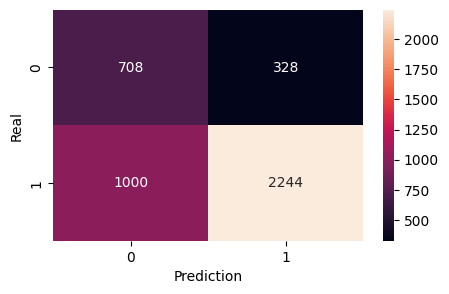


#Support Vector Machine:
               precision    recall  f1-score   support

           0       0.41      0.69      0.51      1036
           1       0.87      0.68      0.76      3244

    accuracy                           0.68      4280
   macro avg       0.64      0.68      0.64      4280
weighted avg       0.76      0.68      0.70      4280



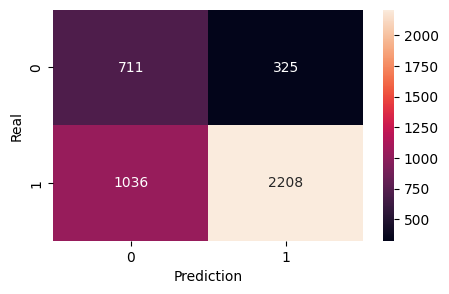


#Neural Network:
               precision    recall  f1-score   support

           0       0.49      0.61      0.55      1036
           1       0.87      0.80      0.83      3244

    accuracy                           0.75      4280
   macro avg       0.68      0.71      0.69      4280
weighted avg       0.78      0.75      0.76      4280



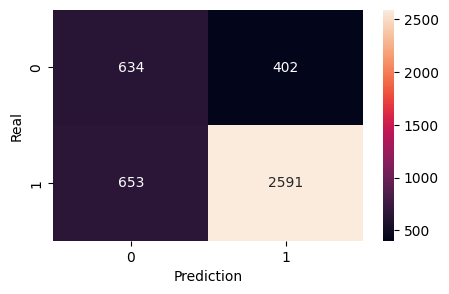

In [34]:
print("Preprocess Method:", method)
# print("\n#Naive Bayes:\n", classification_report(y_test, nb_model))
# plot_confusion_matrix(y_test, nb_model)
print("\n#Random Forest:\n", classification_report(y_test, rf_model))
plot_confusion_matrix(y_test, rf_model)
print("\n#Support Vector Machine:\n", classification_report(y_test, svm_model))
plot_confusion_matrix(y_test, svm_model)
print("\n#Neural Network:\n", classification_report(y_test, nn_model))
plot_confusion_matrix(y_test, nn_model)